In [78]:
# Model taken from the following source: https://www.kaggle.com/code/balavashan/weather-prediction-ensemble-methods

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import scipy
import re
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [3]:
#import the data from the csv file in current directory
data = pd.read_csv("./data/seattle-weather.csv")

data

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
countrain=len(data[data.weather=="rain"])
countsun=len(data[data.weather=="sun"])
countdrizzle=len(data[data.weather=="drizzle"])
countsnow=len(data[data.weather=="snow"])
countfog=len(data[data.weather=="fog"])
print("Percent of Rain:{:2f}%".format((countrain/(len(data.weather))*100)))
print("Percent of Sun:{:2f}%".format((countsun/(len(data.weather))*100)))
print("Percent of Drizzle:{:2f}%".format((countdrizzle/(len(data.weather))*100)))
print("Percent of Snow:{:2f}%".format((countsnow/(len(data.weather))*100)))
print("Percent of Fog:{:2f}%".format((countfog/(len(data.weather))*100)))

Percent of Rain:43.874059%
Percent of Sun:43.805613%
Percent of Drizzle:3.627652%
Percent of Snow:1.779603%
Percent of Fog:6.913073%


In [6]:
data[["precipitation","temp_max","temp_min","wind"]].describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


Pearson correlation: -0.22855481643297043
T Test and P value: Ttest_indResult(statistic=-51.60685279531918, pvalue=0.0)


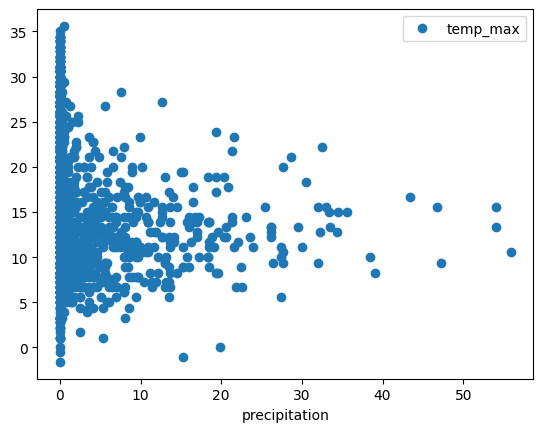

In [7]:
data.plot("precipitation","temp_max",style='o') 
print("Pearson correlation:",data["precipitation"].corr(data["temp_max"]))
print("T Test and P value:",stats.ttest_ind(data["precipitation"],data["temp_max"]))

Pearson correlation: -0.1648566348749548
T Test and P value: Ttest_indResult(statistic=-67.3601643301846, pvalue=0.0)


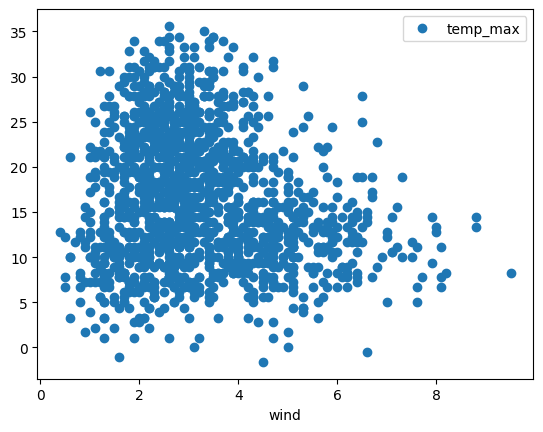

In [8]:
data.plot("wind","temp_max",style='o') 
print("Pearson correlation:",data["wind"].corr(data["temp_max"]))
print("T Test and P value:",stats.ttest_ind(data["wind"],data["temp_max"]))

<Axes: xlabel='temp_max'>

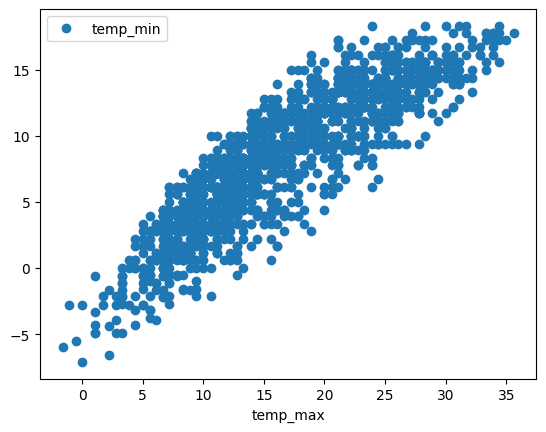

In [9]:
data.plot("temp_max","temp_min",style='o') 

In [10]:
# Check Null values

data.isna().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [11]:
# Preprocessing

In [12]:
df=data.drop(["date"],axis=1)

In [13]:
Q1=df.quantile(0.25)
Q3=df.quantile(0.75)
IQR=Q3-Q1
df=df[~((df<(Q1-1.5*IQR))|(df>(Q3+1.5*IQR))).any(axis=1)]

In [14]:
df.precipitation=np.sqrt(df.precipitation)
df.wind=np.sqrt(df.wind)

In [15]:
df.head()

,precipitation,temp_max,temp_min,wind,weather
0,0.000000,12.8,5.0,2.167948,drizzle
2,0.894427,11.7,7.2,1.516575,rain
4,1.140175,8.9,2.8,2.469818,rain
5,1.581139,4.4,2.2,1.483240,rain
6,0.000000,7.2,2.8,1.516575,rain


In [16]:
# Feature Scaling

In [17]:
lc=LabelEncoder()
df["weather"]=lc.fit_transform(df["weather"])

In [18]:
df.head()

,precipitation,temp_max,temp_min,wind,weather
0,0.000000,12.8,5.0,2.167948,0
2,0.894427,11.7,7.2,1.516575,2
4,1.140175,8.9,2.8,2.469818,2
5,1.581139,4.4,2.2,1.483240,2
6,0.000000,7.2,2.8,1.516575,2


In [19]:
# Data Splitting

In [20]:
x=((df.loc[:,df.columns!="weather"]).astype(int)).values[:,0:]
y=df["weather"].values

In [21]:
df.weather.unique()

array([0, 2, 4, 3, 1])

In [22]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=2)

In [25]:
import mlflow

gbc=GradientBoostingClassifier(subsample=0.5,n_estimators=450,max_depth=5,max_leaf_nodes=25)
gbc.fit(x_train,y_train)
print("Gradient Boosting Accuracy:{:.2f}%".format(gbc.score(x_test,y_test)*100))

mlflow.set_tracking_uri("http://localhost:5000/")

mlflow.set_experiment("Weather_Predictor_Experiment")

desc = "Gradient Boosting Classifier for Weather Prediction"

with mlflow.start_run(run_name = "weather_prediction_experiment", description = desc) as run:

    mlflow.sklearn.autolog()

    depths = [10, 20, 30]
    estimators = [80, 100, 200]

    for d in depths:
        for e in estimators:
            with mlflow.start_run(nested = True) as nested_run:
                mlflow.set_tag("run_id", nested_run.info.run_id)
                gbc=GradientBoostingClassifier(subsample=0.5,n_estimators=450,max_depth=5,max_leaf_nodes=25)
                gbc.fit(x_train,y_train)

                mlflow.log_metric("accuracy", gbc.score(x_test,y_test)*100)

    # best_run = mlflow.search_runs(order_by = ["metrics.accuracy ASC"], max_results = 1)
    # best_run_ID = best_run.iloc[0]["run_id"]
    # print("Best run ID = ", best_run_ID)
    # model_URI = "runs:/" + best_run_ID + "/model"
    # model_version = mlflow.register_model(model_URI, "Weather_Predictor")

2023/06/10 19:18:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f97ed60cb2ca42bc93c4b8881387052a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/06/10 19:19:00 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


Gradient Boosting Accuracy:70.97%


In [31]:
best_run = mlflow.search_runs(order_by = ["metrics.accuracy DESC"], max_results = 1)
best_run_ID = best_run.iloc[0]["run_id"]
print("Best run ID = ", best_run_ID)
model_URI = "runs:/" + best_run_ID + "/model"
# model_version = mlflow.register_model(model_URI, "Weather_Predictor")

Registered model 'Weather_Predictor' already exists. Creating a new version of this model...
2023/06/10 19:24:23 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Weather_Predictor, version 5


Best run ID =  6ebfb15488a64d7881767a8e7bfb1255


Created version '5' of model 'Weather_Predictor'.


In [ ]:
input=[[1.140175,8.9,2.8,2.469818]]
ot=gbc.predict(input)
print("The weather is:")
if(ot==0):
    print("Drizzle")
elif(ot==1):
    print("Fog")
elif(ot==2):
    print("Rain")
elif(ot==3):
    print("snow")
else:
    print("Sun")

The weather is:
Rain


In [111]:
import pickle

model_name = "weather_predictor"
pickle.dump(gbc, open(model_name, 'wb'))